# Frames classification model

In [1]:
#imports
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report

In [2]:
# read in csv with labels for frames
train = pd.read_csv('input/task2_training_frames_labels.csv', sep=';')

In [3]:
# reading in all the frames and saving them to a numpy array

# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and using a standard image size (224, 224, 3)
    img = image.load_img('/home/dl3/task2_trainingFrames/'+train['framename'][i], target_size=(224, 224, 3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/225
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|██████████| 35163/35163 [07:52<00:00, 74.46it/s]


(35163, 224, 224, 3)

In [10]:
# creating train and test set

# separating the target
y = train['isAirframe']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [11]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the architecture of the model

In [12]:
# model without transferlearning based on:
# https://www.machinecurve.com/index.php/2020/03/30/how-to-use-conv2d-with-keras/

In [13]:
inputShape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, (5, 5), strides=(2, 2), activation = 'relu', padding="valid", input_shape=inputShape))
model.add(Conv2D(64, (5, 5), strides=(2, 2), activation='relu', padding="valid"))
model.add(Conv2D(128, (5, 5), strides=(2, 2), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation("softmax"))

In [14]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 110, 110, 32)      2432      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 53, 53, 64)        51264     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
_________________________________________________________________
activation_1 (Activation)    (None, 2)                

In [15]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight_v3.3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [16]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

### Training the model

In [17]:
%%time
# training the model 

version_5 = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=32)

Epoch 1/25
880/880 [==============================] - 17s 19ms/step - loss: 0.0878 - accuracy: 0.9710 - val_loss: 0.0429 - val_accuracy: 0.9852
Epoch 2/25
880/880 [==============================] - 17s 19ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.0331 - val_accuracy: 0.9886
Epoch 3/25
880/880 [==============================] - 16s 18ms/step - loss: 0.0372 - accuracy: 0.9868 - val_loss: 0.0551 - val_accuracy: 0.9781
Epoch 4/25
880/880 [==============================] - 16s 18ms/step - loss: 0.0313 - accuracy: 0.9891 - val_loss: 0.0320 - val_accuracy: 0.9869
Epoch 5/25
880/880 [==============================] - 16s 18ms/step - loss: 0.0277 - accuracy: 0.9903 - val_loss: 0.0346 - val_accuracy: 0.9891
Epoch 6/25
880/880 [==============================] - 16s 18ms/step - loss: 0.0234 - accuracy: 0.9911 - val_loss: 0.0308 - val_accuracy: 0.9906
Epoch 7/25
880/880 [==============================] - 16s 18ms/step - loss: 0.0189 - accuracy: 0.9928 - val_loss: 0.0360 - val_accuracy:

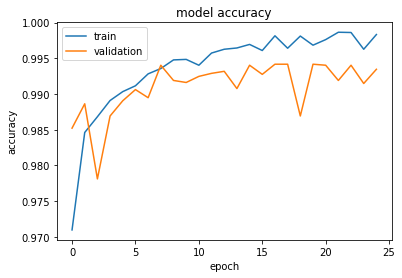

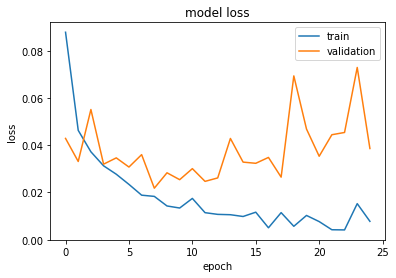

In [18]:
# plot training history
#  "Accuracy"
plt.plot(version_5.history['accuracy'])
plt.plot(version_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# "Loss"
plt.plot(version_5.history['loss'])
plt.plot(version_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation']) #loc='lower right'
plt.show()

In [19]:
model.evaluate(X_train, y_train)

880/880 [==============================] - 8s 9ms/step - loss: 0.0012 - accuracy: 0.9996


[0.0012491998495534062, 0.9996089339256287]

In [20]:
acc = version_5.history['accuracy']
np.amax(acc)

0.9986491203308105

In [21]:
print("[INFO] evaluating network...")
y_test_numeric = y_test.rename(columns={"False": 0, "True": 1})
predictions = model.predict(x=X_test, batch_size=128)
print(classification_report(y_test_numeric.idxmax(axis="columns").values,
                            predictions.argmax(axis=1), target_names=['False', 'True']))

[INFO] evaluating network...
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      1567
        True       1.00      1.00      1.00      5466

    accuracy                           0.99      7033
   macro avg       0.99      0.99      0.99      7033
weighted avg       0.99      0.99      0.99      7033



# Evaluating the frames classification model

## Defining Model architecture and loading weights

In [22]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import math
import os
from glob import glob
from scipy import stats as s

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

In [23]:
# model without transferlearning based on:
# https://www.machinecurve.com/index.php/2020/03/30/how-to-use-conv2d-with-keras/
inputShape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(32, (5, 5), strides=(2, 2), activation = 'relu', padding="valid", input_shape=inputShape))
model.add(Conv2D(64, (5, 5), strides=(2, 2), activation='relu', padding="valid"))
model.add(Conv2D(128, (5, 5), strides=(2, 2), activation='relu', padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# softmax classifier
model.add(Dense(2))
model.add(Activation("softmax"))

In [24]:
# loading the trained weights
model.load_weights("weight_v3.3.hdf5")

# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

## Generating predictions for all test videos

In [25]:
# reading in test labels for verification later
#train = pd.read_csv('input/task2_test_frames_labels_one_video.csv', sep=';')
train = pd.read_csv('input/task2_test_frames_labels_all_videos.csv', sep=';')

# creating the dummy tags
trainLabel = pd.read_csv('input/task2_training_frames_labels.csv', sep=';')
y = trainLabel['isAirframe']
y = pd.get_dummies(y)

## Evaluate model by looking at frame prediction

In [26]:
# creating two lists to store predicted and actual tags
predictFrame = []
actualFrame = []  
frameName = []

# reading actual labels from 
#train = pd.read_csv('input/task2_test_frames_labels_one_video.csv', sep=';')
train = pd.read_csv('input/task2_test_frames_labels_all_videos.csv', sep=';')

# open all frames and convert to np array
prediction_images = []

# loading the images and using a standard image size (224, 224, 3)
for i in tqdm(range(train.shape[0])):
#for i in range(len(images)):
    framename = train['framename'][i]
    img = image.load_img('input/test_frames_all_videos/'+train['framename'][i], target_size=(224, 224, 3))
    #img = image.load_img('temp/'+train['framename'][i], target_size=(224, 224, 3))
    img = image.img_to_array(img)
    img = img/225
    prediction_images.append(img)
    actualFrame.append(train['isAirframe'].loc[train['framename'] == framename].values[0])
    
# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)
    
# predicting tags for each array
prediction = (model.predict(prediction_images) > 0.5).astype("int32")
for pre in prediction:
    if pre[0] == 1:
        predictFrame.append(False)
    elif pre[1] == 1:
        predictFrame.append(True)

100%|██████████| 11710/11710 [01:04<00:00, 180.21it/s]


In [27]:
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predictFrame, actualFrame)*100

96.9940222032451

In [23]:
predictFrame

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [24]:
actualFrame

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 F

In [28]:
# checking predicted and actual frames labels which dont match
count_correct = 0
count_false = 0
for i in range(0, len(predictFrame)):
    if predictFrame[i] == actualFrame[i]:
        count_correct +=1
    else:
        print('frame ' + str(i),predictFrame[i], actualFrame[i])
        #print(frameName[i])
        count_false +=1

test_acc = (count_correct / (count_correct + count_false)) *100
print('Test Accuracy {:.2f}%'.format(test_acc))

frame 128 False True
frame 232 True False
frame 349 True False
frame 510 True False
frame 511 True False
frame 512 True False
frame 513 True False
frame 514 True False
frame 515 True False
frame 516 True False
frame 683 True False
frame 850 True False
frame 971 True False
frame 972 True False
frame 973 True False
frame 974 True False
frame 975 True False
frame 976 True False
frame 977 True False
frame 978 True False
frame 1094 True False
frame 1185 True False
frame 1186 True False
frame 1187 True False
frame 1311 True False
frame 1492 True False
frame 1493 True False
frame 1494 True False
frame 1562 True False
frame 1635 True False
frame 1793 True False
frame 1794 True False
frame 1795 True False
frame 1883 False True
frame 1884 False True
frame 1885 False True
frame 1901 False True
frame 1906 False True
frame 1907 False True
frame 1908 False True
frame 1909 False True
frame 1910 False True
frame 1911 False True
frame 1912 False True
frame 2066 True False
frame 2067 True False
frame 20